In [1]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import glob
import os
torch.manual_seed(0)

In [7]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):

        x = self.conv(x)
        return x

In [3]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_norm = True, activation = "relu", stride = 2, kernel_size = 4, padding = 1):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size= kernel_size, stride = stride, padding = padding, padding_mode = "reflect")

        if use_norm:
            self.norm = nn.InstanceNorm2d(out_channels)
        self.use_norm = use_norm
        self.activation = nn.ReLU(inplace = True) if activation == 'relu' else nn.LeakyReLU(0.2, inplace = True)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_norm == True:
            x = self.norm(x)
        x = self.activation(x)

        return x

In [4]:
class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 2, kernel = 3, use_norm = True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel, stride= stride, padding = 1, output_padding= 1)

        if use_norm == True:
            self.norm = nn.InstanceNorm2d(out_channels)
        self.use_norm = use_norm
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_norm == True:
            x = self.norm(x)
        x = self.activation(x)

        return x


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, stride = 1, kernel = 3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size= kernel, padding=1, stride = stride, padding_mode='reflect')
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=kernel, padding=1, stride = stride, padding_mode='reflect')
        self.norm = nn.InstanceNorm2d(in_channels)
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x):
        original = x.clone()
        x = self.conv1(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = self.activation(x)

        return original + x
        

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, hidden_channels = 64):
        super(Discriminator,self).__init__()

        self.initial = ContractingBlock(in_channels, hidden_channels, stride = 2, activation = "leaky", use_norm = False)
        self.block1 = ContractingBlock(hidden_channels, hidden_channels * 2, stride = 2, activation = "leaky")
        self.block2 = ContractingBlock(hidden_channels * 2, hidden_channels * 4, stride = 2, activation = "leaky")
        self.block3 = ContractingBlock(hidden_channels * 4, hidden_channels * 8, stride = 1, activation = "leaky")
        self.block4 = nn.Conv2d(hidden_channels * 8, 1, kernel_size= 4, stride = 1, padding = 1, padding_mode= "reflect")

    def forward(self, x):
        x = self.initial(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        return torch.sigmoid(x)

In [7]:
def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)
test()

torch.Size([5, 1, 30, 30])


In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_features = 64, num_res = 9):
        super(Generator, self).__init__()
        self. initial = ContractingBlock(in_channels, num_features, kernel_size=7, stride= 1, padding = 3)

        self.contract_blocks = nn.ModuleList(
            [
                ContractingBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ContractingBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )

        self.res_blocks = nn.ModuleList(
            [ResidualBlock(num_features*4) for _ in range(num_res)]
        )

        self.expand_blocks = nn.ModuleList(
            [
                ExpandingBlock(num_features*4, num_features*2, kernel=3, stride=2),
                ExpandingBlock(num_features*2, num_features, kernel=3, stride=2),
            ]
        )

        self.last = nn.Conv2d(num_features, out_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

        self.tanh = nn.Tanh()

    
    def forward(self, x):
        x = self.initial(x)
        
        for block in self.contract_blocks:
            x = block(x)

        for block in self.res_blocks:
            x = block(x)
        
        for block in self.expand_blocks:
            x = block(x)
        
        x = self.last(x)
        return self.tanh(x)


In [37]:
def gen_test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

In [38]:
gen_test()

torch.Size([2, 9, 256, 256])


In [22]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss() 

n_epochs = 20
dim_H = 3
dim_Z = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = "cpu"

In [10]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [11]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))

        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))
    
    def __getitem__(self, idx):
        item_A = self.transform(Image.open(self.files_A[idx % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[idx]]))
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if idx == len(self) - 1:
            self.new_perm()

        return item_A, item_B

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [23]:
gen_HZ = Generator(dim_H, dim_Z).to(device)
gen_ZH = Generator(dim_Z, dim_H).to(device)
gen_opt = torch.optim.Adam(list(gen_HZ.parameters()) + list(gen_ZH.parameters()), lr=lr, betas=(0.5, 0.999))
disc_H = Discriminator(dim_H).to(device)
disc_H_opt = torch.optim.Adam(disc_H.parameters(), lr=lr, betas=(0.5, 0.999))
disc_Z = Discriminator(dim_Z).to(device)
disc_Z_opt = torch.optim.Adam(disc_Z.parameters(), lr=lr, betas=(0.5, 0.999))
load_model = False

if load_model:
    pre_dict = torch.load('cycleGAN.pth')
    gen_HZ.load_state_dict(pre_dict['gen_HZ'])
    gen_ZH.load_state_dict(pre_dict['gen_ZH'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_H.load_state_dict(pre_dict['disc_H'])
    disc_H_opt.load_state_dict(pre_dict['disc_H_opt'])
    disc_z.load_state_dict(pre_dict['disc_Z'])
    disc_Z_opt.load_state_dict(pre_dict['disc_Z_opt'])

else:
    gen_HZ = gen_HZ.apply(weights_init)
    gen_ZH = gen_ZH.apply(weights_init)
    disc_H = disc_H.apply(weights_init)
    disc_Z = disc_Z.apply(weights_init)

In [14]:
######## Disc Loss ########
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    
    disc_fake = disc_X(fake_X.detach())
    disc_fake_loss = adv_criterion(disc_fake, torch.zeros_like(disc_fake))
    disc_real = disc_X(real_X)
    disc_real_loss = adv_criterion(disc_real, torch.ones_like(disc_real))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    
    return disc_loss

In [15]:
###### Adversarial Loss #######

def get_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    
    fake_Y = gen_XY(real_X)
    disc_fake = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake, torch.ones_like(disc_fake))
    
    return adversarial_loss, fake_Y



In [16]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)

    return identity_loss, identity_X


In [17]:
def get_cycle_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    return cycle_loss, cycle_X

In [18]:
def get_gen_loss(real_H, real_Z, gen_HZ, gen_ZH, disc_H, disc_Z, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    
    # Adversarial Loss
    adv_loss_HZ, fake_Z = get_adversarial_loss(real_H, disc_Z, gen_HZ, adv_criterion)
    adv_loss_ZH, fake_H = get_adversarial_loss(real_Z, disc_H, gen_ZH, adv_criterion)
    gen_adversarial_loss = adv_loss_ZH + adv_loss_HZ
    
    # Identity Loss
    identity_loss_H, identity_H = get_identity_loss(real_H, gen_ZH, identity_criterion)
    identity_loss_Z, identity_Z = get_identity_loss(real_Z, gen_HZ, identity_criterion)
    identity_loss = identity_loss_H + identity_loss_Z
    
    # Cycle-consistency Loss
    cycle_loss_H, cycle_H = get_cycle_loss(real_H, fake_Z, gen_ZH, cycle_criterion)
    cycle_loss_Z, cycle_Z = get_cycle_loss(real_Z, fake_H, gen_HZ, cycle_criterion)
    cycle_loss = cycle_loss_H + cycle_loss_Z
    # Total loss
    gen_loss = lambda_identity * identity_loss + lambda_cycle * cycle_loss + gen_adversarial_loss
   
    return gen_loss, fake_H, fake_Z

In [19]:
dataset = ImageDataset("horse2zebra", transform=transform)

In [20]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

  0%|          | 0/1067 [00:00<?, ?it/s]Epoch 0: Step 0: Generator (U-Net) loss: 0.06627676010131836, Discriminator loss: 0.0014972382783889771


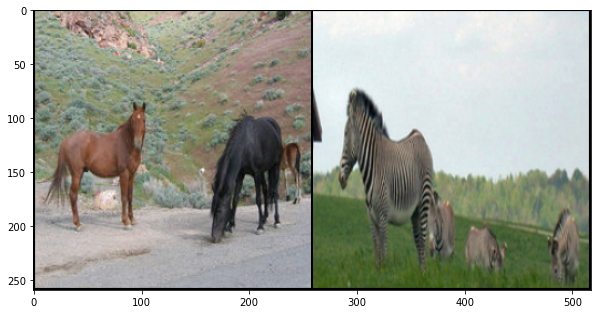

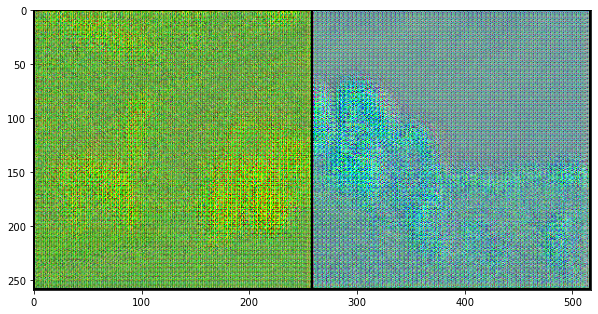

  1%|          | 10/1067 [05:44<9:58:41, 33.98s/it]

In [24]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        
        for real_H, real_Z in tqdm(dataloader):
            # image_width = image.shape[3]
            #real_H = nn.functional.interpolate(real_H, size=target_shape)
            #real_Z = nn.functional.interpolate(real_Z, size=target_shape)
            cur_batch_size = len(real_H)
            real_H = real_H.to(device)
            real_Z = real_Z.to(device)

            ### Update discriminator H ###
            disc_H_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_H = gen_ZH(real_Z)
            disc_H_loss = get_disc_loss(real_H, fake_H, disc_H, adv_criterion)
            disc_H_loss.backward(retain_graph=True) # Update gradients
            disc_H_opt.step() # Update optimizer

            ### Update discriminator Z ###
            disc_Z_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_Z = gen_HZ(real_H)
            disc_Z_loss = get_disc_loss(real_Z, fake_Z, disc_Z, adv_criterion)
            disc_Z_loss.backward(retain_graph=True) # Update gradients
            disc_Z_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_H, fake_Z = get_gen_loss(
                real_H, real_Z, gen_HZ, gen_ZH, disc_H, disc_Z, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_H_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_H, real_Z]), size=(dim_H, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_Z, fake_H]), size=(dim_Z, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({
                        'gen_AB': gen_HZ.state_dict(),
                        'gen_BA': gen_ZH.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_H.state_dict(),
                        'disc_A_opt': disc_H_opt.state_dict(),
                        'disc_B': disc_Z.state_dict(),
                        'disc_B_opt': disc_Z_opt.state_dict()
                    }, f"cycleGAN.pth")
            cur_step += 1
train(True)

In [24]:
 torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  197957 KB |    2573 MB |    4955 MB |    4761 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |  197957 KB |    2573 MB |    4955 MB |    4761 MB |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |  256000 KB |    2924 MB |    2924 MB |    2674 MB |\n|--------------------------------------------------

In [2]:
torch.cuda.empty_cache()

In [6]:
import gc
del variables
gc.collect()

NameError: name 'variables' is not defined